In [1]:
import os
import pandas as pd
import numpy as np
from sklearn import preprocessing
import pickle
import matplotlib.pyplot as plt
#import cv2
#import plotly.graph_objs as go
import seaborn as sns
import matplotlib.cm as cm
import matplotlib
from mpl_toolkits.mplot3d import Axes3D
#import mplcursors 
import random
import torch
from scipy.stats import pearsonr
from Utils import load_dict_from_csv

In [2]:
datasets_folder='/media/Blue2TB1'
datasets=['Jin_22','PAMI18','CVPR18','Fan_NOSSDAV_17']
dataset_colors = cm.rainbow(np.linspace(0, 1, len(datasets)))

In [3]:
def plot_SITI(dataset_name,datasets_folder, annotate_all=False, color='blue'):
    dataset_folder=os.path.join(datasets_folder,dataset_name)
    video_img_folder=os.path.join(dataset_folder, 'video_data')
    videos=os.listdir(video_img_folder)
    video_SIs=[]
    video_TIs=[]
    for video in videos:
        array_folder=os.path.join(video_img_folder,video)
        SI = np.load(os.path.join(array_folder, f'{video}_SI.npy'))
        TI = np.load(os.path.join(array_folder, f'{video}_TI.npy'))
        if np.mean(SI)>200:
            print(video)
            print(SI)
            print(np.mean(SI))
            return 0
        # Aggregating based on ITU-T P.910 (10/2023)
        video_SIs.append(np.mean(SI))
        video_TIs.append(np.mean(TI))
    # Plotting the results
    plt.figure(figsize=(10, 6))
    plt.scatter(video_SIs, video_TIs, color=color, marker='o')

    if annotate_all:
        for i, video in enumerate(videos):
            plt.annotate(video, (video_SIs[i], video_TIs[i]))

    plt.title(f'Spatial and Temporal Information for {dataset_name}')
    plt.xlabel('Spatial Information (SI)')
    plt.ylabel('Temporal Information (TI)')
    plt.grid(True)
    
    plots_folder = os.path.join('Plots', 'SITI')
    os.makedirs(plots_folder, exist_ok=True)
    plot_path = os.path.join(plots_folder, f'{dataset_name}_SITI_plot.png')
    plt.savefig(plot_path)
    plt.show()
    

In [4]:
def plot_all_SITI(datasets_folder, datasets, annotate_all=False):
    plt.figure(figsize=(10, 6))
    colors = cm.rainbow(np.linspace(0, 1, len(datasets)))
    global_min_SI, global_max_SI = float('inf'), float('-inf')
    global_min_TI, global_max_TI = float('inf'), float('-inf')
    video_SIs={}
    video_TIs={}
    for idx, dataset_name in enumerate(datasets):
        dataset_folder = os.path.join(datasets_folder, dataset_name)
        video_img_folder = os.path.join(dataset_folder, 'video_data')
        videos = os.listdir(video_img_folder)
        video_SIs[dataset_name] = []
        video_TIs[dataset_name] = []

        for video in videos:
            array_folder = os.path.join(video_img_folder, video)
            SI = np.load(os.path.join(array_folder, f'{video}_SI.npy'))
            TI = np.load(os.path.join(array_folder, f'{video}_TI.npy'))
            mean_SI, mean_TI=np.mean(SI),np.mean(TI)
            global_min_SI = min(global_min_SI, mean_SI)
            global_max_SI = max(global_max_SI, mean_SI)
            global_min_TI = min(global_min_TI, mean_TI)
            global_max_TI = max(global_max_TI, mean_TI)
            # Aggregating based on ITU-T P.910 (10/2023)
            
            video_SIs[dataset_name].append(mean_SI)
            video_TIs[dataset_name].append(mean_TI)
    
    for idx, dataset_name in enumerate(datasets):
        plt.figure(figsize=(12, 6))

        plt.scatter(video_SIs[dataset_name], video_TIs[dataset_name], color=colors[idx], label=dataset_name)

        if annotate_all:
            for i, video in enumerate(videos):
                plt.annotate(video, (video_SIs[i], video_TIs[i]), fontsize=8, color=colors[idx])

        plt.title(f'Spatial and Temporal Information for {dataset_name}')
        plt.xlabel('Spatial Information (SI)')
        plt.ylabel('Temporal Information (TI)')
        plt.legend()
        plt.xlim(0, global_max_SI+5)
        plt.ylim(0, global_max_TI+5)
        plt.grid(True)
        plots_folder = os.path.join('Plots', 'SITI')
        os.makedirs(plots_folder, exist_ok=True)
        plot_path = os.path.join(plots_folder, f'{dataset_name}_SITI_plot.png')
        plt.savefig(plot_path)
        plt.show()

<Figure size 1000x600 with 0 Axes>

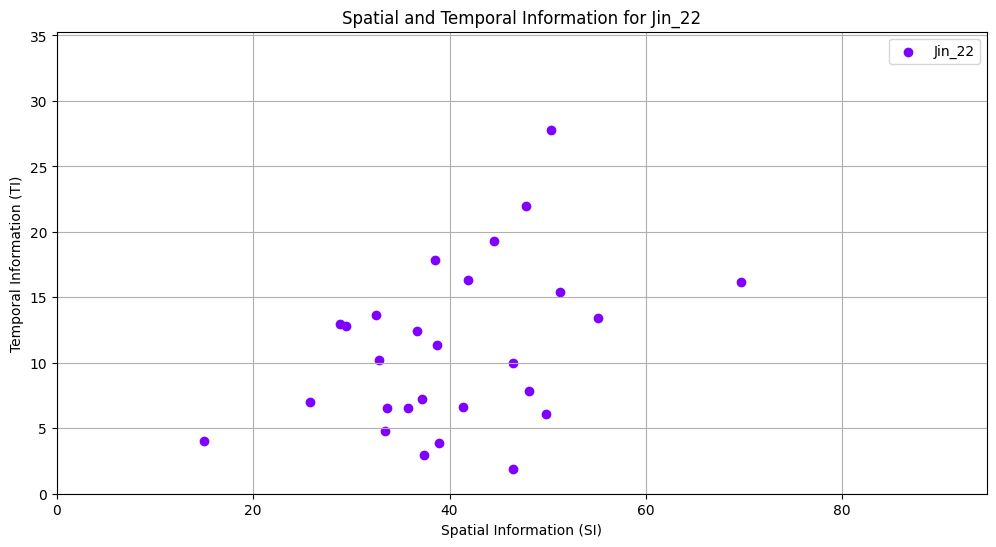

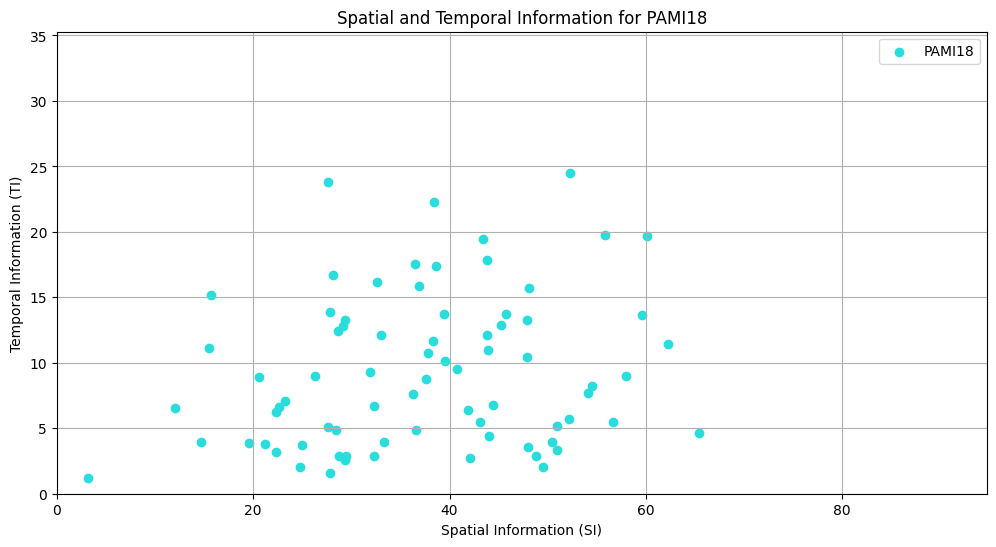

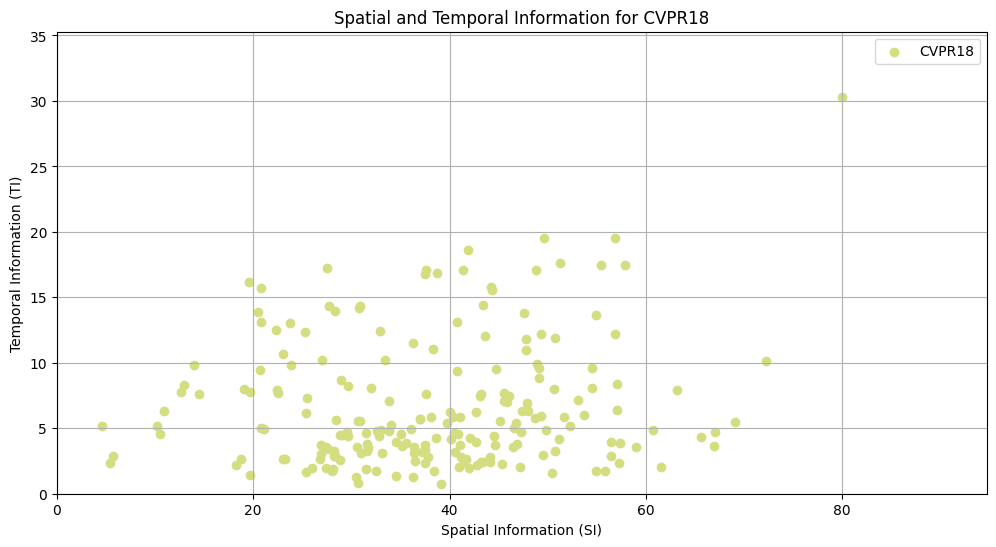

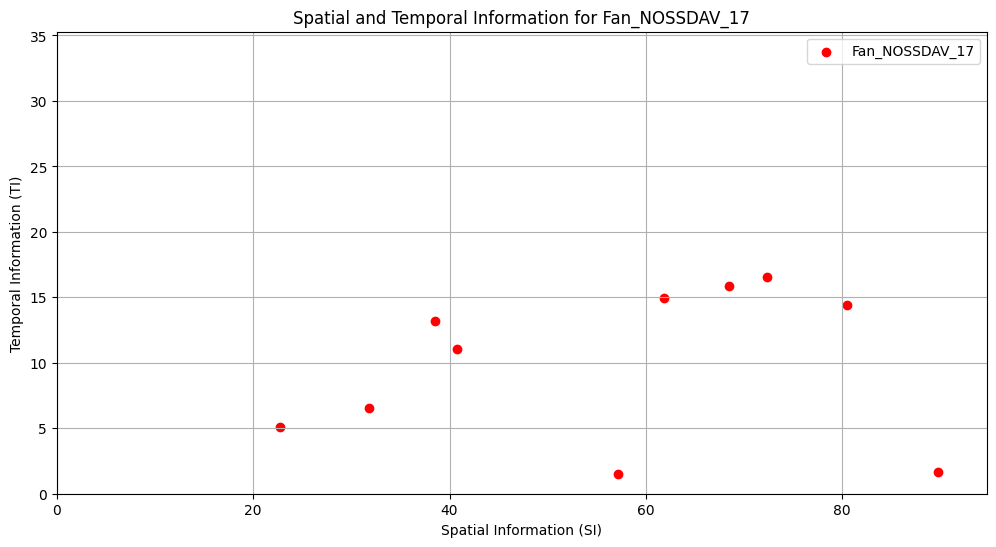

In [5]:
plot_all_SITI(datasets_folder,datasets)

In [6]:
def fetch_c_entropies(datasets_folder, dataset):
    dataset_folder = os.path.join(datasets_folder, dataset)
    video_img_folder = os.path.join(dataset_folder, '5fps_Video_Images')
    data_path = os.path.join(dataset_folder, 'video_data')
    videos = os.listdir(video_img_folder)
    entropies = {}
    
    for video in videos:
        entropy_path = os.path.join(data_path, video, f'{video}_content_entropy.npy')
        
        if os.path.exists(entropy_path):
            entropy = np.load(entropy_path)
            entropies[video] = entropy
            
    return entropies

In [7]:
def plot_mean_entropy_vs_SITI(datasets_folder, dataset):
    dataset_folder = os.path.join(datasets_folder, dataset)

    data_path = os.path.join(dataset_folder, 'video_data')
    
    videos = os.listdir(data_path)
    mean_SIs = []
    mean_TIs = []
    mean_entropies = []
    
    for video in videos:
        # Load SI and TI values
        array_folder = os.path.join(data_path, video)
        SI_path = os.path.join(array_folder, 'video_SI.npy')
        TI_path = os.path.join(array_folder, 'video_TI.npy')
        
        if os.path.exists(SI_path) and os.path.exists(TI_path):
            SI = np.load(SI_path)
            TI = np.load(TI_path)
            mean_SIs.append(np.mean(SI))
            mean_TIs.append(np.mean(TI))
        
        # Load content entropy values
        entropy_path = os.path.join(data_path, video, f'{video}_content_entropy.npy')
        
        if os.path.exists(entropy_path):
            entropy = np.load(entropy_path)
            mean_entropies.append(np.mean(entropy))
    
    # Determine vmin and vmax for the colormap to handle outliers
    vmin = np.percentile(mean_entropies, 5)
    vmax = np.percentile(mean_entropies, 95)
    
    # Plot mean SI vs mean TI with content entropy as colormap
    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(mean_SIs, mean_TIs, c=mean_entropies, cmap='coolwarm', marker='o', vmin=vmin, vmax=vmax)
    
    plt.title(f'Mean TI vs Mean SI with Content Entropy for {dataset}')
    plt.xlabel('Mean Spatial Information (SI)')
    plt.ylabel('Mean Temporal Information (TI)')
    colorbar = plt.colorbar(scatter, label='Mean Content Entropy')
    plt.grid(True)
    plt.tight_layout()
    plots_folder = os.path.join('Plots', 'SITI_entropy')
    os.makedirs(plots_folder, exist_ok=True)
    plot_path = os.path.join(plots_folder, f'{dataset}_SITI_with_entropy_plot.png')
    #plt.savefig(plot_path)
    plt.show()

In [8]:
def plot_mean_entropy_vs_SITI_alldatasets(datasets_folder, datasets,fontsize=12,markersize=5):
    global_min_SI, global_max_SI = float('inf'), float('-inf')
    global_min_TI, global_max_TI = float('inf'), float('-inf')
    video_SIs={}
    video_TIs={}
    video_CEs={}
    
    for idx, dataset_name in enumerate(datasets):
        dataset_folder = os.path.join(datasets_folder, dataset_name)
        video_img_folder = os.path.join(dataset_folder, 'video_data')
        videos = os.listdir(video_img_folder)
        video_SIs[dataset_name] = []
        video_TIs[dataset_name] = []
        video_CEs[dataset_name]=[]
        
        
        for video in videos:
            array_folder = os.path.join(video_img_folder, video)
            SI = np.load(os.path.join(array_folder, f'{video}_SI.npy'))
            TI = np.load(os.path.join(array_folder, f'{video}_TI.npy'))
            CE=np.load(os.path.join(array_folder,f'{video}_content_entropy.npy'))
            mean_SI, mean_TI, mean_CE=np.mean(SI),np.mean(TI),np.mean(CE)
            global_min_SI = min(global_min_SI, mean_SI)
            global_max_SI = max(global_max_SI, mean_SI)
            global_min_TI = min(global_min_TI, mean_TI)
            global_max_TI = max(global_max_TI, mean_TI)
            # Aggregating based on ITU-T P.910 (10/2023)
            
            video_SIs[dataset_name].append(mean_SI)
            video_TIs[dataset_name].append(mean_TI)
            video_CEs[dataset_name].append(mean_CE)
    
    for idx, dataset_name in enumerate(datasets):
        plt.figure(figsize=(10,7))
        dataset_folder = os.path.join(datasets_folder, dataset_name)
        video_img_folder = os.path.join(dataset_folder, 'video_data')
        videos = os.listdir(video_img_folder)
        
        vmin = np.percentile(video_CEs[dataset_name], 5)
        vmax = np.percentile(video_CEs[dataset_name], 95)
        #scatter = plt.scatter(mean_SIs, mean_TIs, c=mean_entropies, cmap='coolwarm', marker='o', vmin=vmin, vmax=vmax)
        scatter=plt.scatter(video_SIs[dataset_name], video_TIs[dataset_name], c=video_CEs[dataset_name],
                            cmap='coolwarm', marker='o', s=markersize,
                            vmin=vmin, vmax=vmax)
        for i, video in enumerate(videos):
            plt.annotate(video, (video_SIs[dataset_name][i], video_TIs[dataset_name][i]), 
                         fontsize=fontsize-6, ha='right', va='bottom')
        
        plt.title(f'Mean TI vs Mean SI with Content Entropy for {dataset_name}')
        plt.xlabel('Mean Spatial Information (SI)',fontsize=fontsize)
        plt.ylabel('Mean Temporal Information (TI)',fontsize=fontsize)
        colorbar = plt.colorbar(scatter)   
        colorbar.set_label(label='Mean Content Entropy', size=fontsize-2)     
        #plt.legend()
        plt.xlim(0, global_max_SI+5)
        plt.ylim(0, global_max_TI+5)
        plt.xticks(fontsize=fontsize-7)
        plt.yticks(fontsize=fontsize-7)
        plt.grid(True)
        plt.tight_layout()
        plots_folder = os.path.join('Plots', 'SITI_entropy')
        os.makedirs(plots_folder, exist_ok=True)
        plot_path = os.path.join(plots_folder, f'{dataset_name}_SITI_with_entropy_plot.png')
        plt.savefig(plot_path)
        plt.show()    

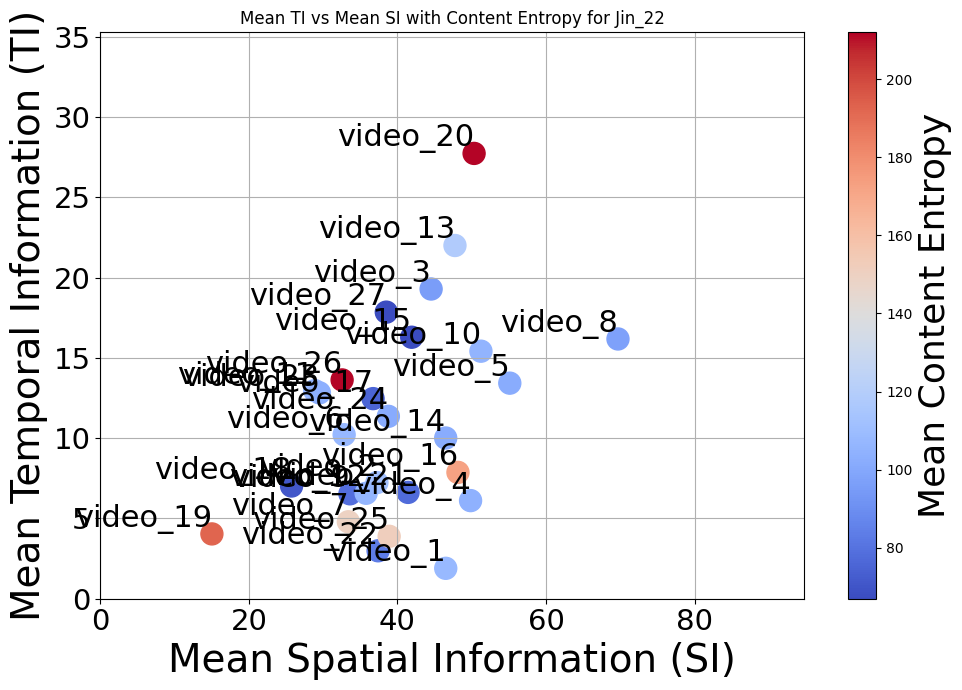

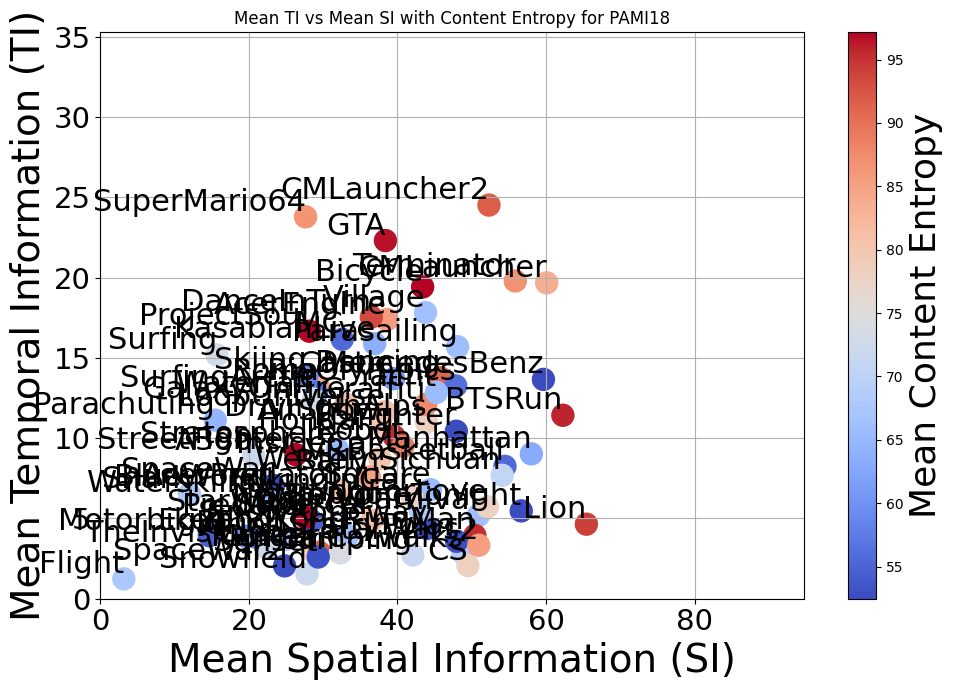

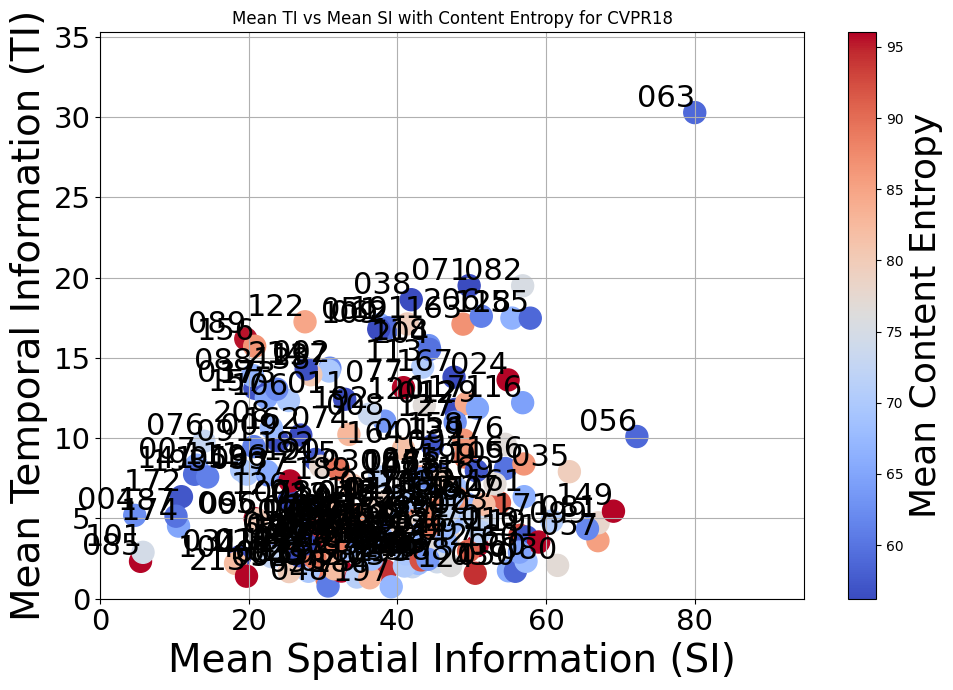

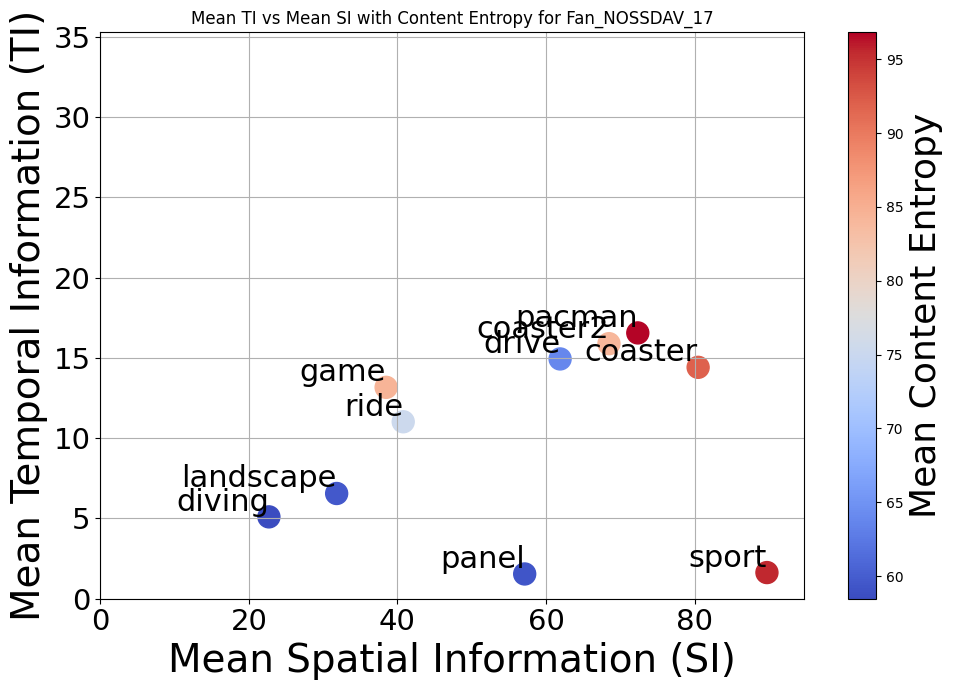

In [9]:
plot_mean_entropy_vs_SITI_alldatasets(datasets_folder,datasets,fontsize=28,markersize=250)

In [10]:
def fetch_entropies(datasets_folder,dataset):
    dataset_folder = os.path.join(datasets_folder, dataset)
    data_path = os.path.join(dataset_folder, 'video_data')
    videos = os.listdir(data_path)
    entropies={}
    aes={}
    IEs={}
    for video in videos:
        entropy_path = os.path.join(data_path, video, f'{video}_content_entropy.npy')
        ae_path=os.path.join(data_path,video, f'{video}_AEs.npy')
        IE_path=os.path.join(data_path, video, f'{video}_IEs.npy')
        entropy=np.load(entropy_path)
        ae=np.load(ae_path)
        ie=np.load(IE_path)
        entropies[video]=entropy
        aes[video]=ae
        IEs[video]=ie
    return entropies,aes,IEs

In [11]:
def plot_mean_AEs_vs_entropy(entropies, aes,dataset,color='blue',fontsize=12,markersize=50):
    mean_entropies = []
    mean_AEs = []
    videos=list(entropies.keys())
    for video in entropies:
        #if np.mean(entropies[video])>200:
            #continue
        mean_entropies.append(np.mean(entropies[video]))
        mean_AEs.append(np.mean(aes[video]))
        
    plt.figure(figsize=(8, 6))
    plt.scatter(mean_AEs, mean_entropies, color=color, marker='o',s=markersize)
    for i, video in enumerate(videos):
        plt.annotate(video, (mean_AEs[i], mean_entropies[i]), fontsize=fontsize-6, ha='right', va='bottom')
    #for i, video in enumerate(entropies):
    #    plt.annotate(video, (mean_AEs[i], mean_entropies[i]), fontsize=8)
    #plt.title(f'{dataset} Mean Entropy vs Mean AE')
    plt.xlabel('Mean Actual Entropy',fontsize=fontsize)
    plt.ylabel('Mean Content Entropy',fontsize=fontsize)
    plt.xticks(fontsize=fontsize-7)
    plt.yticks(fontsize=fontsize-7)
    plt.grid(True)
    plots_folder = os.path.join('Plots', 'Entropies')
    os.makedirs(plots_folder, exist_ok=True)
    plot_path = os.path.join(plots_folder, f'{dataset}_contententropy_vs_AE.png')
    plt.savefig(plot_path)
    plt.show()

In [12]:
def plot_mean_AEs_vs_entropy_all_datasets(datasets_folder,datasets,color,dataset_names,fontsize=12,markersize=50):
    global_min_AE, global_max_AE = float('inf'), float('-inf')
    global_min_CE, global_max_CE = float('inf'), float('-inf')
    video_AEs={}
    video_CEs={}
    for idx,dataset in enumerate(datasets):
        ces,aes,_=fetch_entropies(datasets_folder,dataset)
        mean_CEs = []
        mean_AEs = []
        for video in ces:
            if np.mean(ces[video])>150:
                continue
            mean_CE=np.mean(ces[video])
            mean_AE=np.mean(aes[video])
            global_min_AE = min(global_min_AE, mean_AE)
            global_max_AE = max(global_max_AE, mean_AE)
            global_min_CE = min(global_min_CE, mean_CE)
            global_max_CE = max(global_max_CE, mean_CE)
            mean_CEs.append(mean_CE)
            mean_AEs.append(mean_AE)
        video_AEs[dataset]=mean_AEs
        video_CEs[dataset]=mean_CEs
    
    plt.figure(figsize=(8, 6))
    for idx, dataset in enumerate(datasets):
        
        
        plt.scatter(video_AEs[dataset], video_CEs[dataset], color=color[idx], marker='o',label=dataset_names[idx],s=markersize)
        #for i, video in enumerate(entropies):
        #    plt.annotate(video, (mean_AEs[i], mean_entropies[i]), fontsize=8)
    #plt.title(f'{dataset} Mean Entropy vs Mean AE')
    plt.xlabel('Mean AEs',fontsize=fontsize)
    plt.ylabel('Mean Content Entropy', fontsize=fontsize)
    plt.ylim(global_min_CE-2, global_max_CE+2)
    plt.xlim(global_min_AE-0.1, global_max_AE + 0.1)
    plt.xticks(fontsize=fontsize-4)
    plt.yticks(fontsize=fontsize-4)
    plt.legend()
    plt.grid(True)
    plots_folder = os.path.join('Plots', 'Entropies')
    os.makedirs(plots_folder, exist_ok=True)
    plot_path = os.path.join(plots_folder, f'all_datasets_contententropy_vs_AE.png')
    plt.savefig(plot_path)
    plt.show()

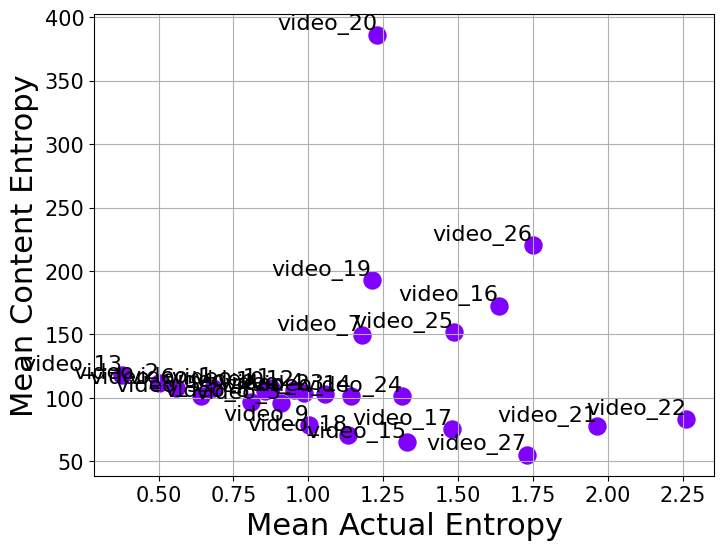

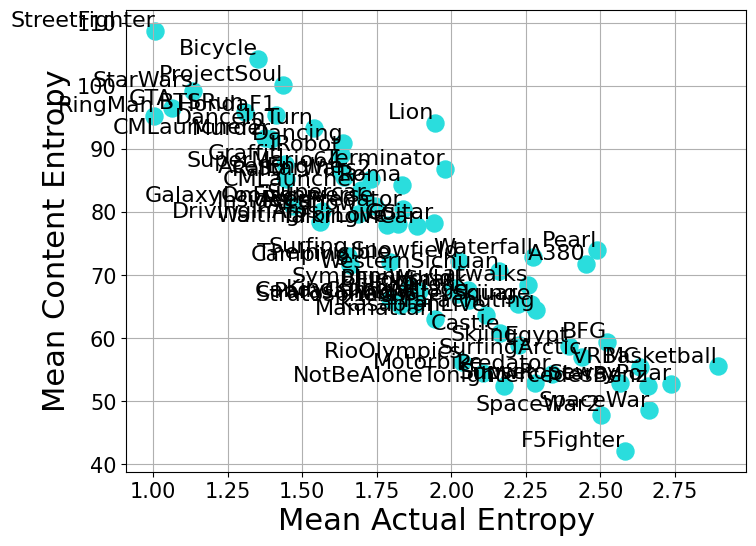

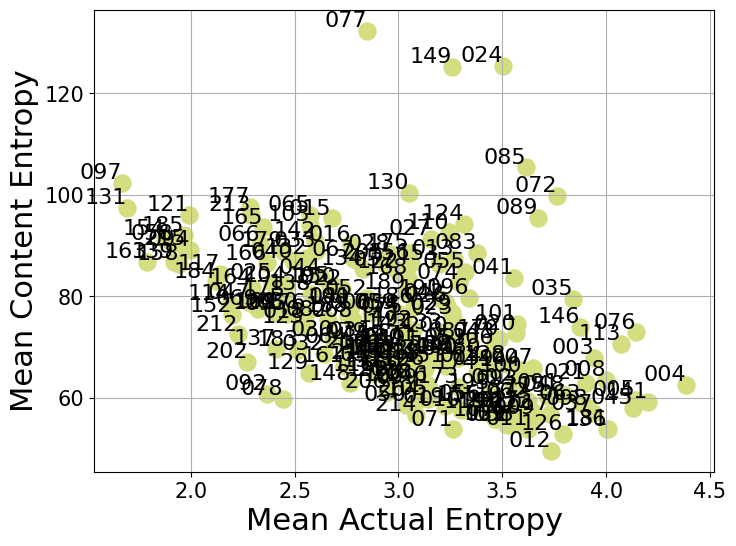

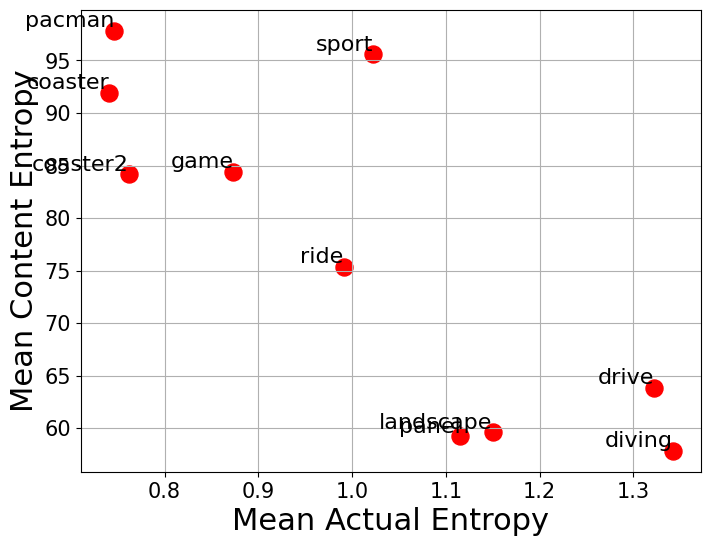

In [13]:
for idx,dataset in enumerate(datasets):
    c_entropies,aes,IEs=fetch_entropies(datasets_folder,dataset)
    plot_mean_AEs_vs_entropy(c_entropies, aes, dataset,color=dataset_colors[idx],fontsize=22,markersize=150)

In [14]:
dataset_names=['MM22','PAMI18','CVPR18','NOSSDAV17']

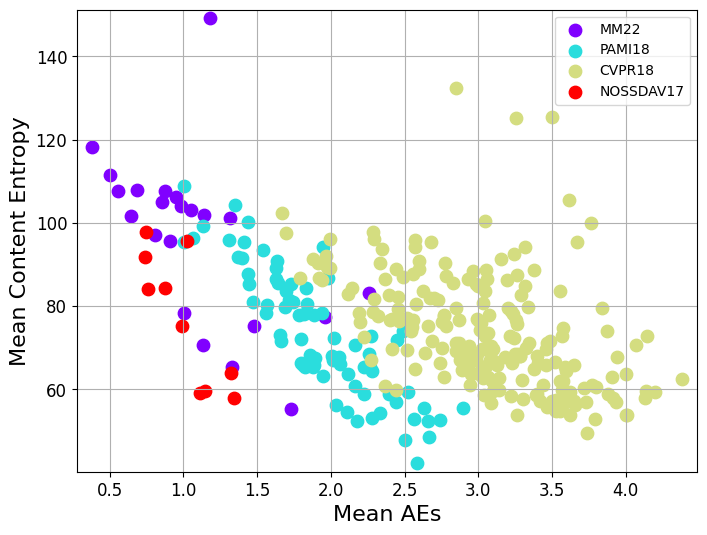

In [15]:
plot_mean_AEs_vs_entropy_all_datasets(datasets_folder,datasets,dataset_colors,dataset_names=dataset_names,fontsize=16,markersize=80)

In [16]:
def plot_train_test(datasets_folder,dataset, ces,aes,fontsize=12,markersize=50):
    dataset_dir=os.path.join(datasets_folder,dataset)
    vid_data_dir=os.path.join(dataset_dir,'video_data')
    split_path=os.path.join(dataset,'splits','test_vids')
    test_vids=load_dict_from_csv(split_path,columns=['video'])
    test_vids=[vid[0] for vid in test_vids]
    all_vids=os.listdir(vid_data_dir)
    train_vids=list(set(all_vids)-set(test_vids))
    
    test_AEs=[]
    test_CEs=[]
    
    for video in test_vids:
        test_CEs.append(np.mean(ces[video]))
        test_AEs.append(np.mean(aes[video]))
     
    train_AEs=[]
    train_CEs=[]    
    for video in train_vids:
        train_CEs.append(np.mean(ces[video]))
        train_AEs.append(np.mean(aes[video]))
        
    plt.figure(figsize=(8, 6))
    plt.scatter(train_AEs, train_CEs, color='blue', marker='o', label='training videos',s=markersize)
    plt.scatter(test_AEs, test_CEs, color='red', marker='o', label='testing videos',s=markersize)
    #for i, video in enumerate(entropies):
    #    plt.annotate(video, (mean_AEs[i], mean_entropies[i]), fontsize=8)
    #plt.title(f'{dataset} Mean Entropy vs Mean AE')
    plt.xlabel('Mean Actual Entropy',fontsize=fontsize)
    plt.ylabel('Mean Content Entropy',fontsize=fontsize)
    plt.xticks(fontsize=fontsize-7)
    plt.yticks(fontsize=fontsize-7)
    plt.grid(True)
    plots_folder = os.path.join('Plots', 'Splits')
    os.makedirs(plots_folder, exist_ok=True)
    plot_path = os.path.join(plots_folder, f'{dataset}_train_test_split.png')
    plt.savefig(plot_path)
    plt.show()

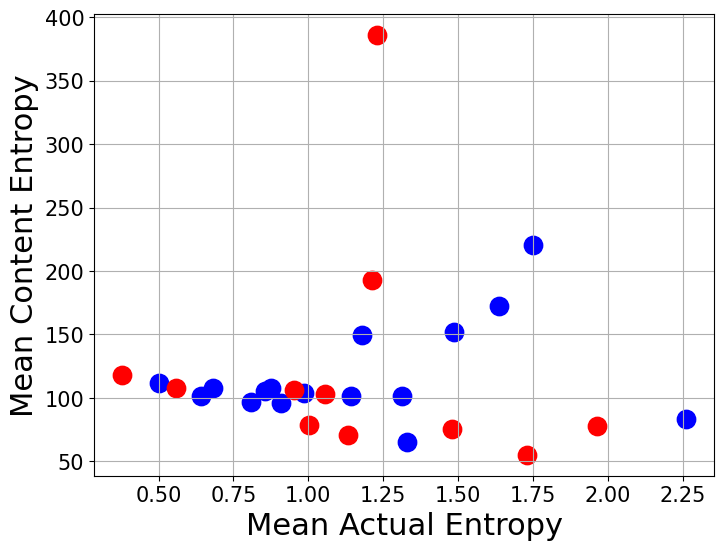

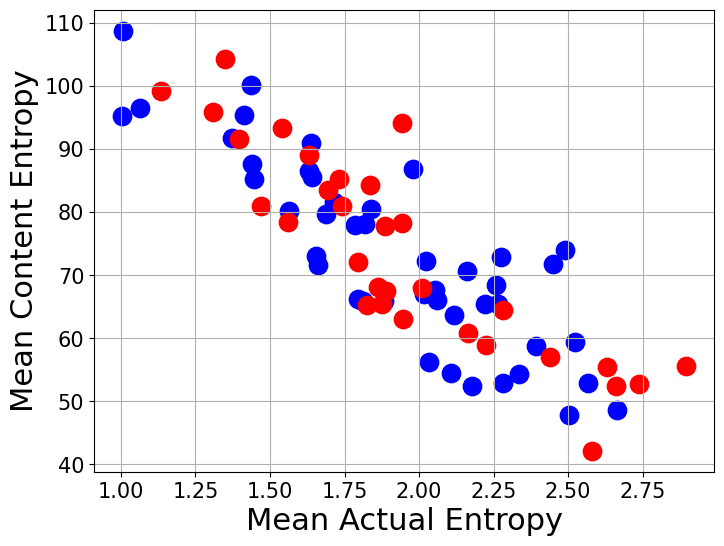

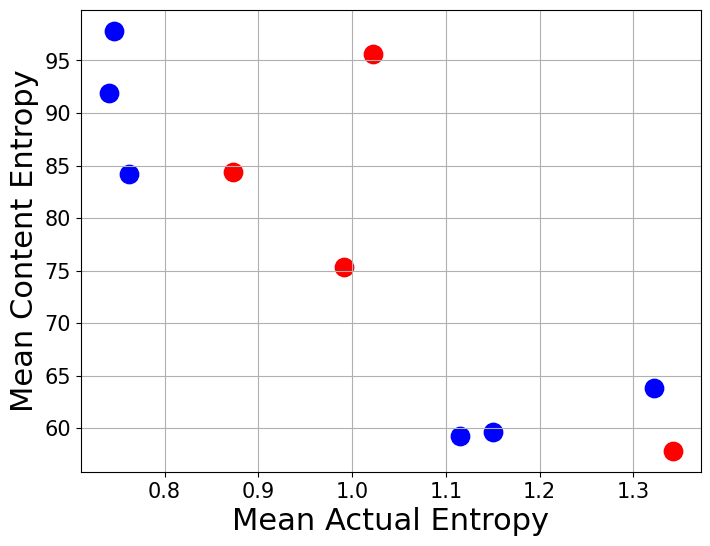

In [17]:
used_datasets=['Jin_22', 'PAMI18', 'Fan_NOSSDAV_17']
for idx,dataset in enumerate(used_datasets):
    ces,aes,IEs=fetch_entropies(datasets_folder,dataset)
    plot_train_test(datasets_folder,dataset,ces,aes,fontsize=22,markersize=175)

In [18]:
datasets

['Jin_22', 'PAMI18', 'CVPR18', 'Fan_NOSSDAV_17']

In [19]:
test='TRACK__init_5_in_5_out_25_end_25_Epoch500'

In [20]:
def get_model_name(model):
    model=model.split('_')
    if model[0]=='pos':
        model_name='pos_only'
    else:
        model_name=model[0]
    if model_name=='DVMS':
        model_name=model_name+'_'+model[-2][0]+'='+model[-2][1:]
    return model_name

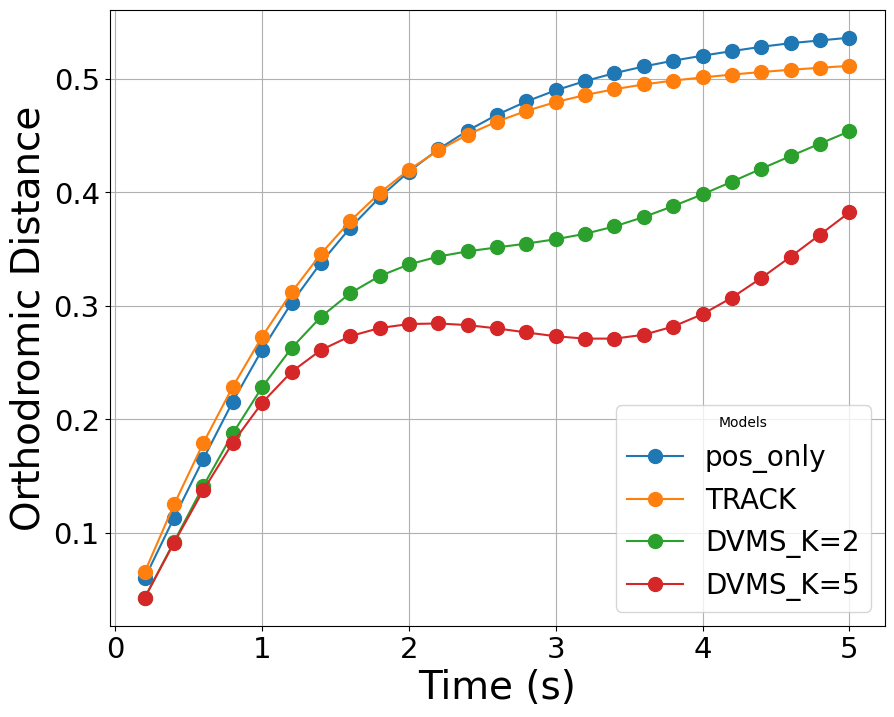

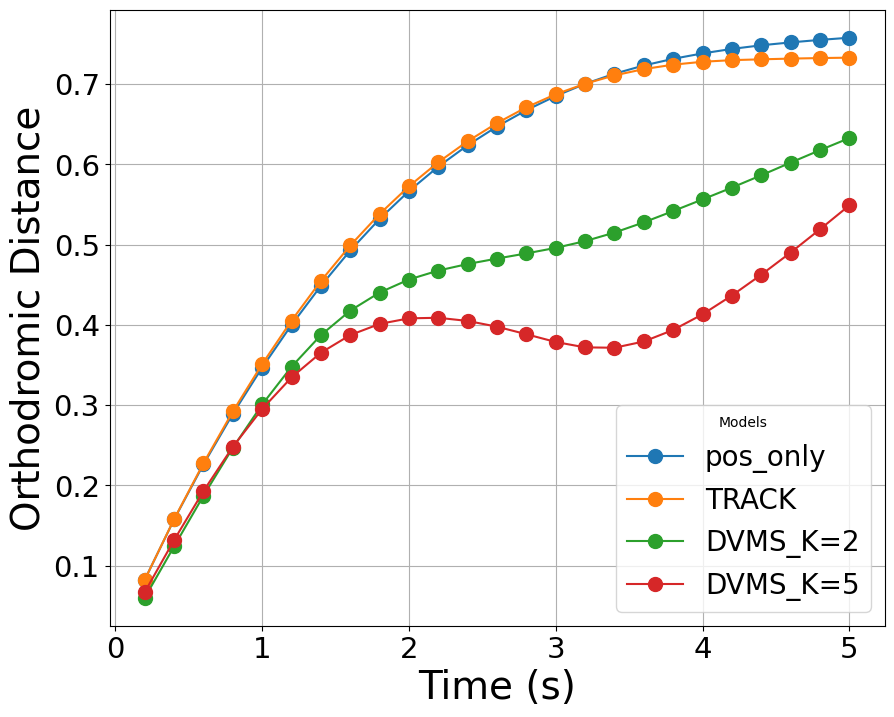

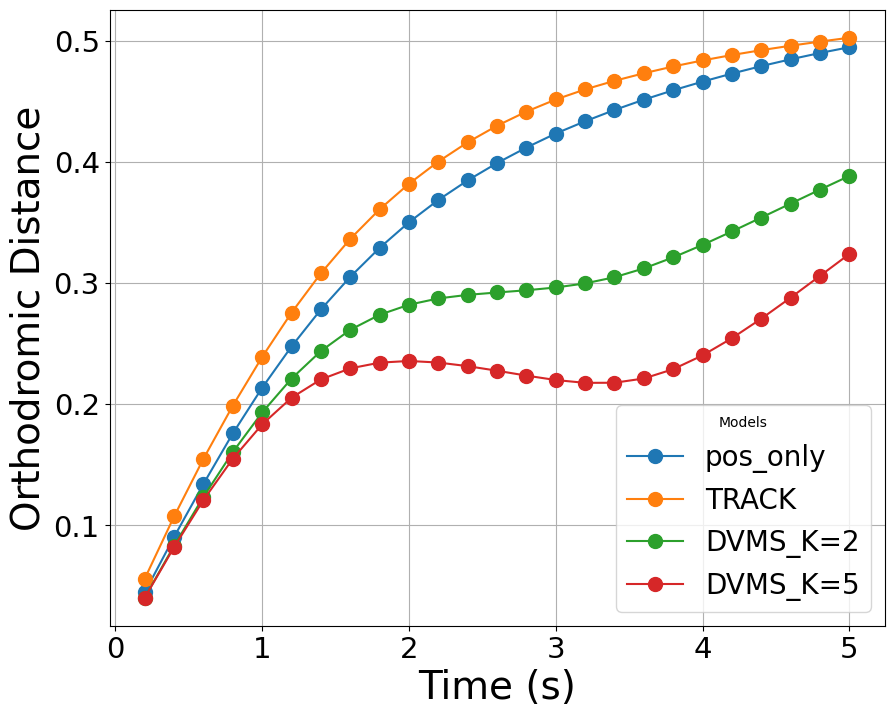

In [21]:
plot_paths='TestPlots'
datasets=os.listdir(plot_paths)
dataset_names=['PAMI18','NOSSDAV17','MM22']
fontsize=28
markersize=10
for idx,dataset in enumerate(datasets):
    paths=os.path.join(plot_paths,dataset)
    models=os.listdir(paths)
    model_dist_values = {}
    model_names=[get_model_name(model) for model in models]
    for model,model_name in zip(models,model_names):
        model_path=os.path.join(paths,model)
        dist_values_path=os.path.join(model_path,'orth_dist_values.npy')
        if os.path.exists(dist_values_path):
            # Load the dist_values from the file
            dist_values = np.load(dist_values_path)
            
            # Store dist_values in the dictionary with model name as key
            model_dist_values[model_name] = dist_values
        else:
            print(f"File {dist_values_path} does not exist.")

    reordered=['pos_only','TRACK','DVMS_K=2','DVMS_K=5']
    reordered_values={key: model_dist_values[key] for key in reordered}
    
    if reordered_values:
        # Generate the timestamps based on 5fps
        timestamps = np.arange(0.2, 5.1, 0.2)  # Adjust according to your timestamp range and fps
        
        # Plotting
        plt.figure(figsize=(10, 8))
        # Plot each model's dist_values with a label
        for model_name, dist_values in reordered_values.items():
            #model_name=get_model_name(model)
            plt.plot(timestamps, dist_values, marker='o', linestyle='-', label=model_name,markersize=markersize)
        
        #plt.title(f'Dataset: {dataset_names[idx]} - Orthodromic Distance Across Models')
        plt.xlabel('Time (s)',fontsize=fontsize)
        plt.ylabel('Orthodromic Distance',fontsize=fontsize)
        plt.legend(title='Models',fontsize=fontsize-8)
        plt.xticks(fontsize=fontsize-7)
        plt.yticks(fontsize=fontsize-7)
        
        plt.grid(True)
        plots_folder = os.path.join('Plots', 'Model_Performances')
        os.makedirs(plots_folder, exist_ok=True)
        # Save plot to the dataset path
        plot_file = os.path.join(plots_folder, f'{dataset}_model_dist_values.png')
        plt.savefig(plot_file)
        plt.show()
        plt.close()
        
        #print(f"Plot saved at: {plot_file}")
    else:
        print(f"No dist_values found for dataset: {dataset}")

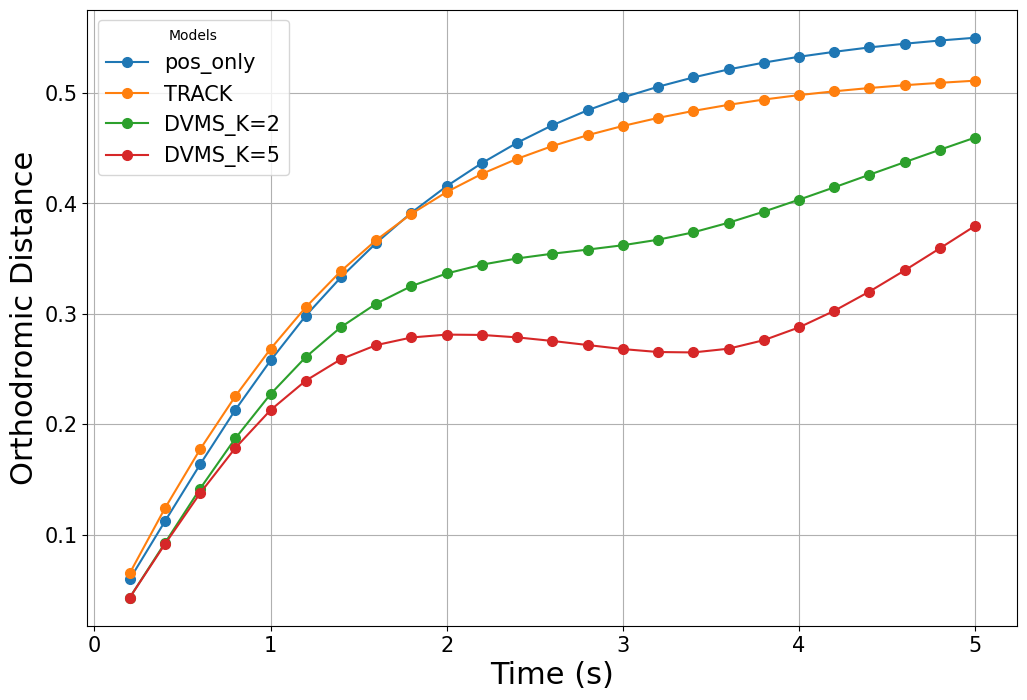

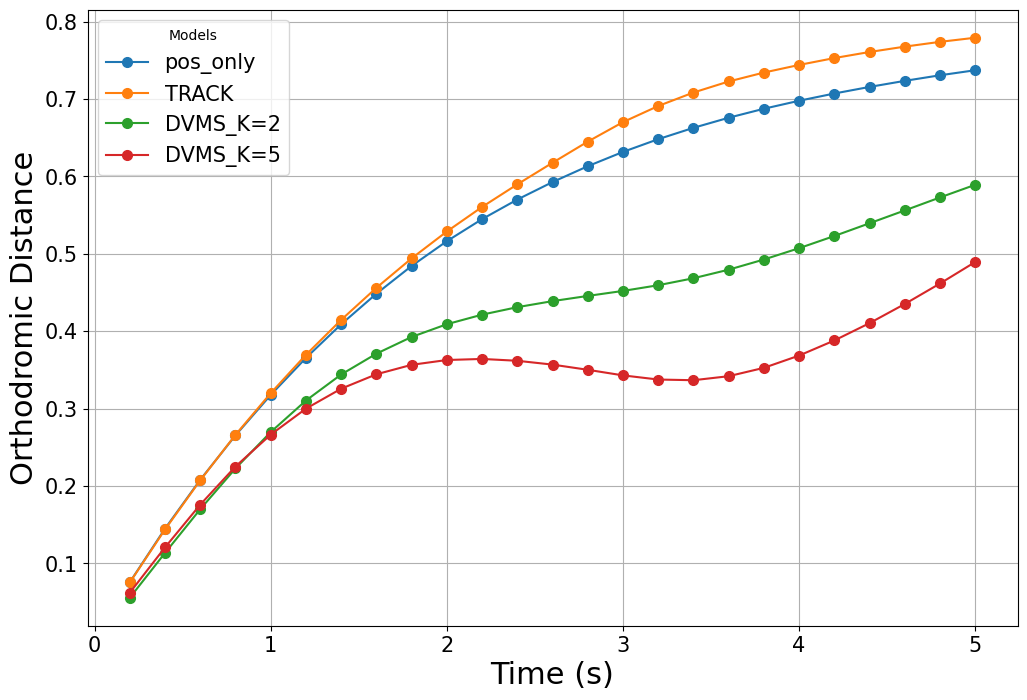

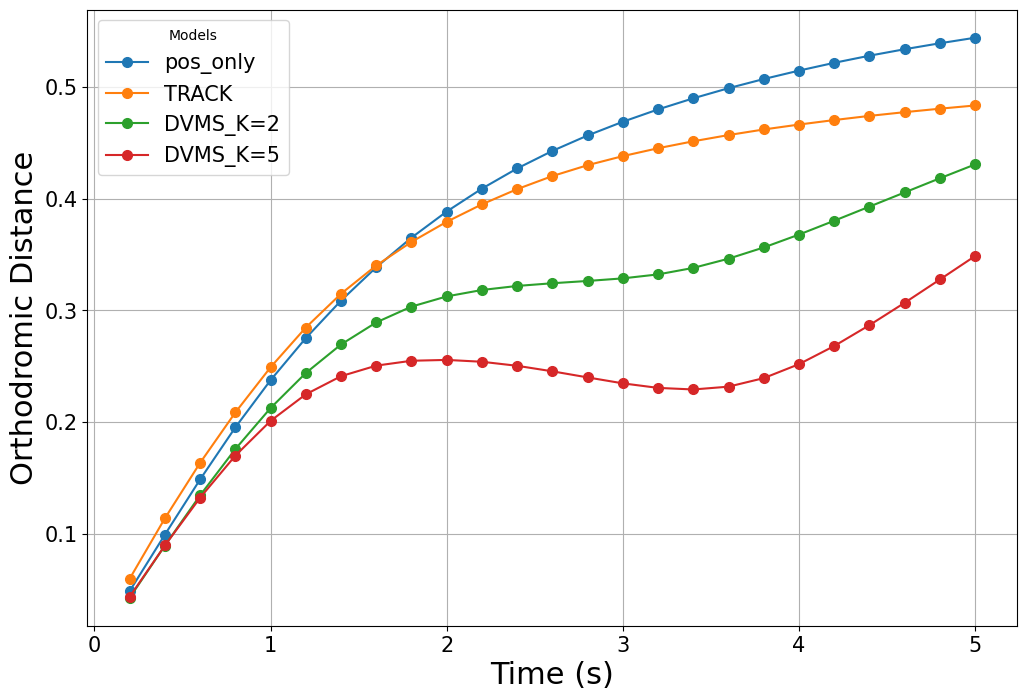

In [22]:
plot_paths='New_User_TestPlots'
datasets=os.listdir(plot_paths)
dataset_names=['PAMI18','NOSSDAV17','MM22']
fontsize=22
for idx,dataset in enumerate(datasets):
    paths=os.path.join(plot_paths,dataset)
    models=os.listdir(paths)
    model_dist_values = {}
    model_names=[get_model_name(model) for model in models]
    for model,model_name in zip(models,model_names):
        model_path=os.path.join(paths,model)
        dist_values_path=os.path.join(model_path,'orth_dist_values.npy')
        if os.path.exists(dist_values_path):
            # Load the dist_values from the file
            dist_values = np.load(dist_values_path)
            
            # Store dist_values in the dictionary with model name as key
            model_dist_values[model_name] = dist_values
        else:
            print(f"File {dist_values_path} does not exist.")

    reordered=['pos_only','TRACK','DVMS_K=2','DVMS_K=5']
    reordered_values={key: model_dist_values[key] for key in reordered}
    
    if reordered_values:
        # Generate the timestamps based on 5fps
        timestamps = np.arange(0.2, 5.1, 0.2)  # Adjust according to your timestamp range and fps
        
        # Plotting
        plt.figure(figsize=(12, 8))
        # Plot each model's dist_values with a label
        for model_name, dist_values in reordered_values.items():
            #model_name=get_model_name(model)
            plt.plot(timestamps, dist_values, marker='o', linestyle='-', label=model_name, markersize=7)
        
        #plt.title(f'Dataset: {dataset_names[idx]} - Orthodromic Distance Across Models')
        plt.xlabel('Time (s)',fontsize=fontsize)
        plt.ylabel('Orthodromic Distance',fontsize=fontsize)
        plt.legend(title='Models',fontsize=fontsize-7)
        plt.grid(True)
        plots_folder = os.path.join('Plots', 'Model_Performances')
        os.makedirs(plots_folder, exist_ok=True)
        # Save plot to the dataset path
        plot_file = os.path.join(plots_folder, f'{dataset}_model_dist_values_new_user.png')
        plt.xticks(fontsize=fontsize-7)
        plt.yticks(fontsize=fontsize-7)
        #plt.savefig(plot_file)
        plt.show()
        plt.close()
        
        #print(f"Plot saved at: {plot_file}")
    else:
        print(f"No dist_values found for dataset: {dataset}")

In [23]:
def generate_unique_colors(n_colors):
    """
    Generate a list of unique colors.
    :param n_colors: Number of unique colors needed
    :return: List of unique colors
    """
    colormap = plt.get_cmap('tab20')  # You can choose a different colormap if needed
    colors = [colormap(i / n_colors) for i in range(n_colors)]
    return colors

In [24]:
def plot_combined_distances_for_model(dist_values_per_video, video_colors, model, ax,dataset,fontsize=22, markersize=10):
    """Plot combined orthodromic distances for all videos in a model."""
    timestamps = np.arange(0.2, 5.1, 0.2)  # 0.2 to 5 seconds with 5 fps
    
    for video, dist_values in dist_values_per_video.items():
        color = video_colors.get(video, 'black')  # Default to 'black' if video color not found
        ax.plot(timestamps, dist_values, marker='o', linestyle='-', color=color, label=video,markersize=markersize)
    
    #ax.set_title(f'Model: {model} - Orthodromic Distances Across Videos for {dataset}')
    ax.set_xlabel('Time (s)',fontsize=22)
    ax.set_ylabel('Orthodromic Distance',fontsize=22)
    ax.legend(loc='best',fontsize=fontsize-7)
    
    #ax.grid(True)

In [25]:
vid_plot_paths='Test_vid_plots'

In [26]:

def plot_video_charts(dataset, markersize=7,fontsize=22):
    paths=os.path.join(vid_plot_paths,dataset)
    models=os.listdir(paths)
    models=['DVMS__init_5_in_5_out_25_end_25_K5_Epoch500']
    temp_path=os.path.join(paths,models[0])
    output_path=os.path.join('Plots','PerVideo_test')
    os.makedirs(output_path, exist_ok=True)
    videos=os.listdir(temp_path)
    # Generate unique colors
    num_videos = len(videos)
    colors = generate_unique_colors(num_videos)
    # Create a mapping of videos to colors
    video_colors = dict(zip(videos, colors))
    #entropies,aes,IEs=fetch_entropies(datasets_folder,dataset,videos)
    #fig=plot_mean_AEs_vs_entropy(entropies,aes,dataset, video_colors)
    model_dist_values={}
    for model in models:
        model_path=os.path.join(paths,model)
        
        for video in videos:
            video_path=os.path.join(model_path,video)
            #print(video_path)
            dist_values_path=os.path.join(video_path,'orth_dist_values.npy')
            if os.path.exists(dist_values_path):
                # Load the dist_values from the file
                dist_values = np.load(dist_values_path)
                if model not in model_dist_values:
                        model_dist_values[model] = {}
                # Store dist_values in the dictionary with model name as key
                model_dist_values[model][video] = dist_values
            else:
                print(f"File {dist_values_path} does not exist.")
    for model, dist_values_per_video in model_dist_values.items():
            fig, ax = plt.subplots(figsize=(9, 7))
            plot_combined_distances_for_model(dist_values_per_video, video_colors, model, ax, dataset)
            
            plot_file = os.path.join(output_path, f'{dataset}_{model}_combined_distances.png')
            plt.tight_layout()
            plt.xticks(fontsize=fontsize-7)
            plt.yticks(fontsize=fontsize-7)
            ax.legend(loc='best',fontsize=fontsize-7)
            plt.savefig(plot_file)
            
            plt.show()
            
            #print(f"Combined distances plot saved at: {plot_file}")
    
    

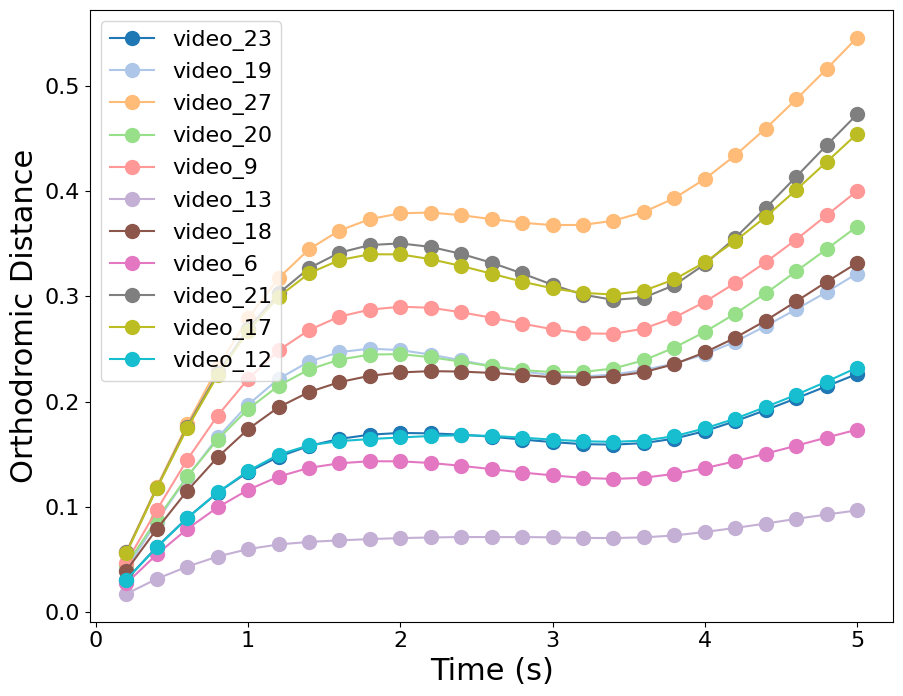

In [27]:
plot_video_charts('Jin_22',markersize=7,fontsize=23)

In [28]:
def fetch_entropies(datasets_folder,dataset, videos):
    dataset_folder = os.path.join(datasets_folder, dataset)
    #video_img_folder = os.path.join(dataset_folder, '5fps_Video_Images')
    data_path = os.path.join(dataset_folder, 'video_data')
    #videos = os.listdir(video_img_folder)
    entropies={}
    aes={}
    IEs={}
    for video in videos:
        entropy_path = os.path.join(data_path, video, f'{video}_content_entropy.npy')
        ae_path=os.path.join(data_path,video, f'{video}_AEs.npy')
        IE_path=os.path.join(data_path, video, f'{video}_IEs.npy')
        entropy=np.load(entropy_path)
        ae=np.load(ae_path)
        ie=np.load(IE_path)
        entropies[video]=entropy
        aes[video]=ae
        IEs[video]=ie
    return entropies,aes,IEs

In [29]:
timestamps = np.arange(0.2, 5.1, 0.2)
def plot_test_entropies(dataset,scale=100,fontsize=22,markersize=80):
    paths=os.path.join(vid_plot_paths,dataset)
    models=os.listdir(paths)
    temp_path=os.path.join(paths,models[0])
    videos=os.listdir(temp_path)
    # Generate unique colors
    num_videos = len(videos)
    colors = generate_unique_colors(num_videos)
    # Create a mapping of videos to colors
    video_colors = dict(zip(videos, colors))
    entropies,aes,IEs=fetch_entropies(datasets_folder,dataset,videos)
    fig=plot_mean_AEs_vs_entropy(entropies,aes, IEs, dataset, video_colors,scale,fontsize=fontsize)

In [30]:
def plot_mean_AEs_vs_entropy(entropies, aes, ies, dataset, video_colors, scale=100,fontsize=22):
    mean_entropies = []
    mean_AEs = []
    fig, ax = plt.subplots(figsize=(8, 6))
    mean_IEs=[np.mean(ies[video]) for video in ies]
    min_IE = min(mean_IEs)
    max_IE = max(mean_IEs)
    video_data = []  # List to store (video, mean_AE, color)
    for video,color in video_colors.items():
        mean_entropies.append(np.mean(entropies[video]))
        mean_AEs.append(np.mean(aes[video]))
        mean_entropy = np.mean(entropies[video])
        mean_AE = np.mean(aes[video])
        mean_IE=np.mean(ies[video])
        if max_IE != min_IE:  # Avoid division by zero
            marker_size = 1 + 9 * (mean_IE - min_IE) / (max_IE - min_IE)
        else:
            marker_size = 1 
        marker_size=marker_size*scale
        ax.scatter(mean_AE, mean_entropy, color=color, marker='o', label=video,s=marker_size)
        video_data.append((video, mean_AE, color))
        #ax.annotate(video, (mean_AE, mean_entropy), fontsize=8, ha='left', color='black',xytext=offset,textcoords='offset points')
    
    #plt.figure(figsize=(8, 6))
    #plt.scatter(mean_AEs, mean_entropies, color=color, marker='o')
    #for i, video in enumerate(entropies):
    #    plt.annotate(video, (mean_AEs[i], mean_entropies[i]), fontsize=8)
    #plt.title(f'Test videos {dataset} Mean Entropy vs Mean AE')
    #plt.xlabel('Mean AEs')
    #plt.ylabel('Mean Content Entropy')
    #plt.grid(True)
    #plots_folder = os.path.join('Plots', 'Entropies')
    #os.makedirs(plots_folder, exist_ok=True)not 
    #plot_path = os.path.join(plots_folder, f'{dataset}_contententropy_vs_AE.png')
    #plt.savefig(plot_path)
    # Create a new figure and axis
    video_data.sort(key=lambda x: x[1], reverse=True)
    plot_dir=os.path.join('Plots','PerVideo_dist')
    os.makedirs(plot_dir, exist_ok=True)
    output_path=os.path.join(plot_dir,f'{dataset}_per_video_ce_ae.png')
    
    #mean_dist_values=
    # Plot the data
    #ax.set_title(f'Test videos {dataset} Mean Entropy vs Mean AE')
    ax.set_xlabel('Mean AEs',fontsize=fontsize)
    ax.set_ylabel('Mean Content Entropy',fontsize=fontsize)
    handles = [
        plt.Line2D(
            [0], [0], 
            marker='o', 
            color='w', 
            markerfacecolor=color, 
            markersize=10, 
            label=video
        ) 
        for video, _, color in video_data
    ]
    
    ax.legend(handles=handles, fontsize=fontsize-8, title='Videos', title_fontsize=fontsize-7)
    ax.grid(True)
    plt.xticks(fontsize=fontsize-7)
    plt.yticks(fontsize=fontsize-7)
    plt.savefig(output_path)
    
    # Return the figure
    return fig
    #return plt

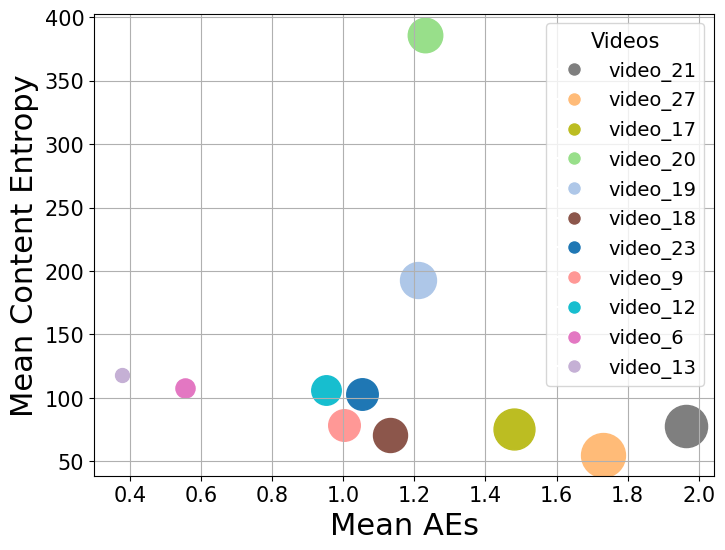

In [31]:
plot_test_entropies('Jin_22',scale=100)

In [32]:
data_path='Plots/Full_video_plots'
datasets=os.listdir(data_path)

In [33]:
def fetch_user_list(datasets_folder,dataset,videos):
    users={}
    for video in videos:
        data_path=os.path.join(datasets_folder,dataset,'video_data',video)
        users[video]=np.load(os.path.join(data_path,f'{video}_users.npy'))
    return users

In [34]:
def get_user_IE(vid_IEs,vid_users,username):
    user_index = np.where(vid_users == username)[0][0]
    user_IE=vid_IEs[user_index]
    return user_IE

def fetch_timestamps(datasets_folder,dataset,videos):
    tstamps={}
    for video in videos:
        data_path=os.path.join(datasets_folder,dataset,'video_data',video)
        tstamps[video]=np.load(os.path.join(data_path,f'{video}_timestamps.npy'))
    return tstamps

In [35]:
from scipy.signal import find_peaks

In [36]:
def plot_individual_performance(data_path,dataset,fontsize=22,markersize=10):
    models=os.listdir(os.path.join(data_path,dataset))
    
    for model in models:
        vid_path=os.path.join(data_path,dataset,model)
        videos=os.listdir(vid_path)
        entropies,aes,IEs=fetch_entropies(datasets_folder,dataset,videos)
        #print(IEs['ride'].shape)
        all_users=fetch_user_list(datasets_folder,dataset,videos)
        timestamps=fetch_timestamps(datasets_folder,dataset,videos)
        #print(users)
        #return 0
        for video in videos:
            user_path=os.path.join(vid_path,video)
            users=os.listdir(user_path)
            vid_CEs=entropies[video]
            vid_IEs=IEs[video]

            vid_users=all_users[video]
            vid_timestamps=timestamps[video]
            user_IEs=0
            all_dist_1=0
            all_dist_2=0
            all_dist_3=0
            all_dist_4=0
            all_dist_5=0
            all_dist_next=0
            for user in users:
                user_IE=get_user_IE(vid_IEs,vid_users,user)
                
                user_IEs+=user_IE
                
                result_path=os.path.join(user_path,user)
                dist_next_values=np.load(os.path.join(result_path,'orth_dist_next_values.npy'))
                dist_1_values=np.load(os.path.join(result_path,'orth_dist_1_values.npy'))
                dist_2_values=np.load(os.path.join(result_path,'orth_dist_2_values.npy'))
                dist_3_values=np.load(os.path.join(result_path,'orth_dist_3_values.npy'))
                dist_4_values=np.load(os.path.join(result_path,'orth_dist_4_values.npy'))
                dist_5_values=np.load(os.path.join(result_path,'orth_dist_5_values.npy'))
                
                all_dist_1+=dist_1_values
                all_dist_2+=dist_2_values
                all_dist_3+=dist_3_values
                all_dist_4+=dist_4_values
                all_dist_5+=dist_5_values
                all_dist_next+=dist_next_values
                
                
                #peaks_dist_5,_=find_peaks(dist_5_values)
                #peaks_vid_CE, _ = find_peaks(vid_CEs)

                # Get the peak timings
                #peak_times_dist_5 = timestamps_5[peaks_dist_5]
                #peak_times_vid_CE = vid_timestamps[peaks_vid_CE]
                """ plt.figure(figsize=(14, 8))
                plt.plot(vid_timestamps, user_IE, marker='o', label='User_IE')
                plt.plot(vid_timestamps, vid_CEs, marker='o', label='Vid_CE')
                # Plotting each distance set
                plt.plot(timestamps_next, dist_next_values, marker='o', label='Dist Next (0.2s)')
                plt.plot(timestamps_1, dist_1_values, marker='o', label='Dist 1 (1s)')
                #plt.plot(timestamps_2, dist_2_values, marker='o', label='Dist 2 (2s)')
                plt.plot(timestamps_3, dist_3_values, marker='o', label='Dist 3 (3s)')
                #plt.plot(timestamps_4, dist_4_values, marker='o', label='Dist 4 (4s)')
                plt.plot(timestamps_5, dist_5_values, marker='o', label='Dist 5 (5s)')

                plt.title(f'Performance Over Time for {model} - {video} - {user}', fontsize=fontsize)
                plt.xlabel('Time (seconds)', fontsize=fontsize)
                plt.ylabel('Distance Values', fontsize=fontsize)
                plt.grid(True)
                plt.legend(fontsize=fontsize-4)
                plt.xticks(fontsize=fontsize-4)
                plt.yticks(fontsize=fontsize-4) """
                # Create a figure and axis
                #fig, ax1 = plt.subplots(figsize=(14, 8))

                # Plotting user_IE and distance values on the primary y-axis
                #ax1.plot(vid_timestamps, user_IE, marker='o', label='User_IE')
                #ax1.plot(timestamps_next, dist_next_values, marker='o', label='Dist Next (0.2s)')
                #ax1.plot(timestamps_1, dist_1_values, marker='o', label='Dist 1 (1s)')
                #ax1.plot(timestamps_3, dist_3_values, marker='o', label='Dist 3 (3s)')
                #ax1.plot(timestamps_5, dist_5_values, marker='o', label='Dist 5 (5s)')
                """ plt.plot(peak_times_dist_5, dist_5_values[peaks_dist_5], 'rx', label='Dist 5 Peaks')

                # Set labels and title for the primary y-axis
                ax1.set_xlabel('Time (seconds)', fontsize=fontsize)
                ax1.set_ylabel('Distance Values', fontsize=fontsize)
                ax1.set_title(f'Performance Over Time for {model} - {video} - {user}', fontsize=fontsize)
                ax1.grid(True)
                ax1.legend(fontsize=fontsize-4)
                ax1.tick_params(axis='y', labelsize=fontsize-4)
                ax1.tick_params(axis='x', labelsize=fontsize-4)

                # Create a secondary y-axis for vid_CEs
                ax2 = ax1.twinx()
                #ax2.plot(vid_timestamps, vid_CEs, marker='o', color='orange', label='Vid_CE')
                plt.plot(peak_times_vid_CE, vid_CEs[peaks_vid_CE], 'rx',color=
                         'orange', label='Vid_CE Peaks')

                ax2.set_ylabel('Vid_CE Values', fontsize=fontsize)
                ax2.legend(fontsize=fontsize-4, loc='upper right')
                ax2.tick_params(axis='y', labelsize=fontsize-4)

                plt.show()
                return """
            dist_next_values=all_dist_next/len(users)
            dist_1_values=all_dist_1/len(users)
            dist_2_values=all_dist_2/len(users)
            dist_3_values=all_dist_3/len(users)
            dist_4_values=all_dist_4/len(users)
            dist_5_values=all_dist_5/len(users)
            mean_IE=user_IEs/len(users)
            timestamps_next=timestamps_next = np.arange(5, 5 + len(dist_next_values) * 1) / 5
            timestamps_1 = np.arange(9, 9 + len(dist_1_values) * 1) / 5  # 1s intervals
            #timestamps_2 = np.arange(14, 14 + len(dist_2_values) * 5, 5) / 5
            timestamps_3 = np.arange(19, 19 + len(dist_3_values) * 1) / 5
            #timestamps_4 = np.arange(24, 24 + len(dist_4_values) * 5, 5) / 5
            timestamps_5 = np.arange(29, 29 + len(dist_5_values) * 1) / 5
            plt.figure(figsize=(14, 8))
            #plt.plot(vid_timestamps, mean_IE, marker='o', label='User_IE')
            # Plotting each distance set
            plt.plot(timestamps_next, dist_next_values, marker='o', label='Dist Next (0.2s)', color='blue')
            #plt.plot(timestamps_1, dist_1_values, marker='o', label='Dist 1 (1s)')
                #plt.plot(timestamps_2, dist_2_values, marker='o', label='Dist 2 (2s)')
            #plt.plot(timestamps_3, dist_3_values, marker='o', label='Dist 3 (3s)')
            #plt.plot(timestamps_4, dist_4_values, marker='o', label='Dist 4 (4s)')
            plt.plot(timestamps_5, dist_5_values, marker='o', label='Dist 5 (5s)', color='green')
            plt.legend(loc='upper left', fontsize=fontsize-4)
            plt.xlabel('Time (seconds)', fontsize=fontsize)
            plt.ylabel('Distance Values', fontsize=fontsize)
            plt.grid(True)
            plt.xticks(fontsize=fontsize-4)
            plt.yticks(fontsize=fontsize-4)
            # Secondary y-axis
            ax2 = plt.gca().twinx()
            shift=5
            shifted_vid_CEs=np.concatenate([np.full(shift, np.nan), vid_CEs])
            shifted_vid_CEs = shifted_vid_CEs[:len(vid_timestamps)]
            ax2.plot(vid_timestamps, shifted_vid_CEs, marker='o', color='red', label='Content Entropy')
            ax2.set_ylabel('Vid_CE', fontsize=fontsize, color='red')
            ax2.tick_params(axis='y', labelcolor='red')
            plt.title(f'Performance Over Time for {model} - {video}', fontsize=fontsize)
            
            # Legends for both axes
            
            ax2.legend(loc='upper right', fontsize=fontsize-4)
            return
                

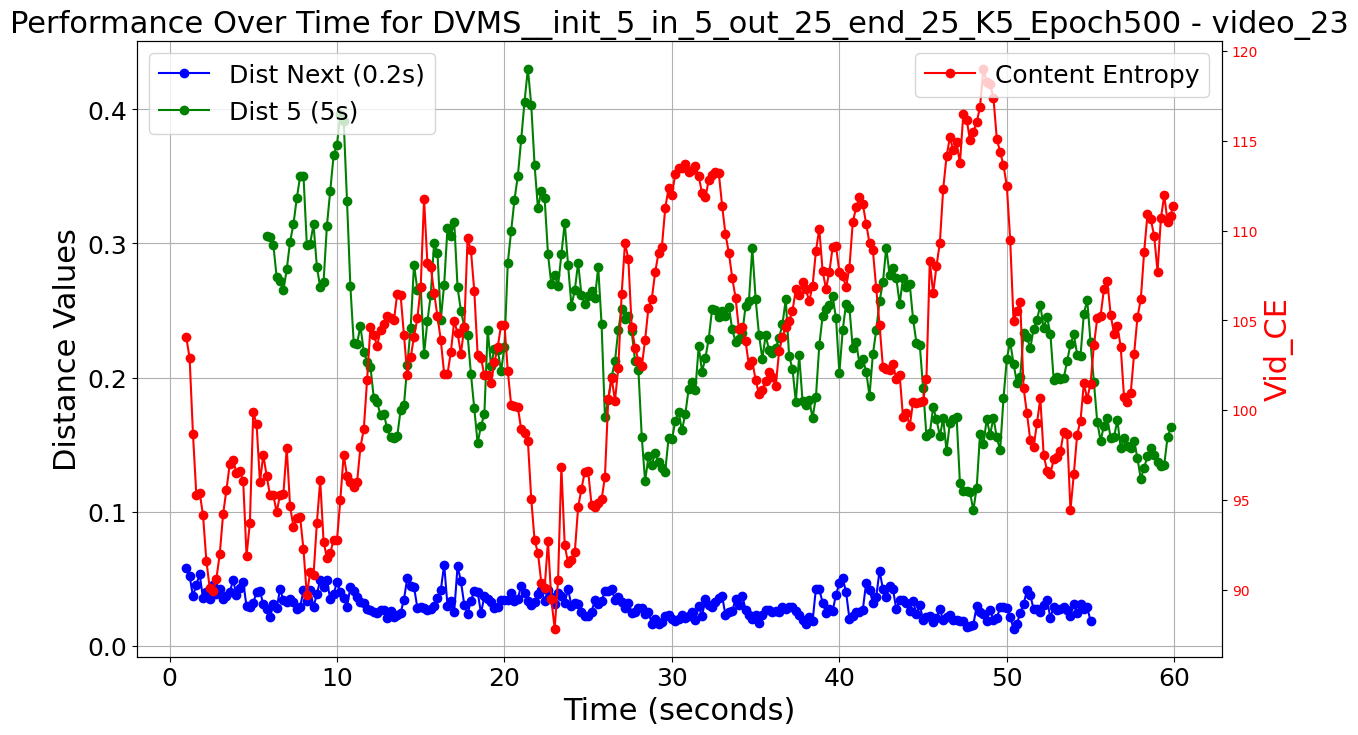

In [37]:
plot_individual_performance(data_path,datasets[2])

In [38]:
datasets_folder

'/media/Blue2TB1'

In [39]:
from mpl_toolkits.mplot3d import Axes3D

In [40]:
def plot_traj_xyt(data_folder,dataset,vid_name):
    data_path=os.path.join(data_folder,dataset,'video_data',vid_name)
    saliency_path=os.path.join(data_folder,dataset,'true_saliency')
    saliency=np.load(os.path.join(saliency_path,f'{vid_name}.npy'))
    timestamps=np.load(os.path.join(data_path,f'{vid_name}_timestamps.npy'))
    trajectory=np.load(os.path.join(data_path,f'{vid_name}_unit_vectors.npy'))
    user_idx = np.random.randint(trajectory.shape[0])  # Select a random user (from n users)
    user_trajectory = trajectory[user_idx]
    # Extract x, y, and time (t) from the user trajectory
    x = user_trajectory[:, 0]  # X-coordinate
    y = user_trajectory[:, 1]  # Y-coordinate
    t = timestamps  # Time as the vertical axis

    # Plot the 3D trajectory (x, y, t)
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')
    
    ax.plot(x, y, t, marker='o', label=f'User {user_idx}', color='b')

    # Add vertical lines at x=0 and y=0
    ax.plot([0, 0], [0, 0], [t.min(), t.max()], color='black', linewidth=2, label='Vertical at (x=0, y=0)')

    # Turn off grid and unnecessary spines
    ax.grid(False)  # Disable grid
    ax.xaxis.pane.fill = False  # Remove background pane for X axis
    ax.yaxis.pane.fill = False  # Remove background pane for Y axis
    ax.zaxis.pane.fill = False  # Remove background pane for Z axis
    ax.xaxis.line.set_color((1, 1, 1, 0))  # Hide x-axis line
    ax.yaxis.line.set_color((1, 1, 1, 0))  # Hide y-axis line
    ax.zaxis.line.set_color((1, 1, 1, 0))  # Hide z-axis line
    # Set labels and title
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Time (seconds)')
    ax.set_title(f'Trajectory of User {user_idx} - {vid_name}')
    
    plt.legend()
    plt.show()

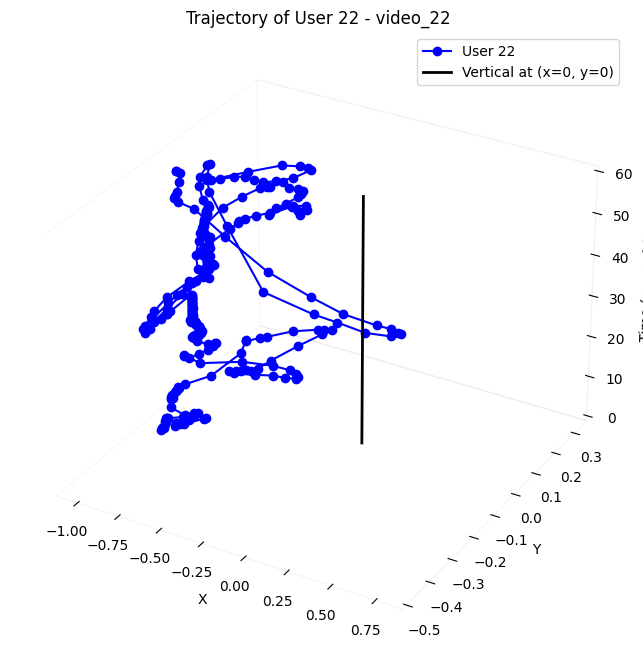

In [41]:
plot_traj_xyt(datasets_folder,'Jin_22', 'video_22')

In [42]:
import plotly.graph_objects as go


In [51]:

def plot_3D_trajectory_with_time(data_folder, dataset, vid_name):
    # Load the data
    data_path = os.path.join(data_folder, dataset, 'video_data', vid_name)
    timestamps = np.load(os.path.join(data_path, f'{vid_name}_timestamps.npy'))
    trajectory = np.load(os.path.join(data_path, f'{vid_name}_unit_vectors.npy'))

    n_users, t, _ = trajectory.shape
    random_users = np.random.choice(n_users, 4, replace=False)  # Select 4 random users
    time_steps = timestamps[:t]

    # Plot for each random user
    for user_idx in random_users:
        user_trajectory = trajectory[user_idx, :, :2]  # Get x and y components
        fig = go.Figure()

        fig.add_trace(go.Scatter3d(
            x=user_trajectory[:, 0],
            y=user_trajectory[:, 1],
            z=time_steps,
            mode='lines+markers',
            marker=dict(
                size=4,
                color=time_steps,  # Color based on time
                colorscale='Viridis',
                colorbar=dict(title="Time (s)")
            ),
            name=f'User {user_idx + 1}',
            line=dict(color='darkblue', width=2)
        ))

        # Update layout for each plot
        fig.update_layout(
            title=f'User Gaze Trajectory Over Time - {vid_name} (User {user_idx + 1})',
            scene=dict(
                xaxis_title='X Coordinate',
                yaxis_title='Y Coordinate',
                zaxis_title='Time (seconds)'
            ),
            width=800,
            height=600
        )
        fig.show()

    # Now calculate the average trajectory and variance across all users
    avg_trajectory = np.mean(trajectory[:, :, :2], axis=0)  # Mean across users
    var_trajectory = np.var(trajectory[:, :, :2], axis=0)  # Variance across users (for X and Y components)

    # Plot the average trajectory in 3D
    fig_avg = go.Figure()

    # Plot mean trajectory
    fig_avg.add_trace(go.Scatter3d(
        x=avg_trajectory[:, 0],
        y=avg_trajectory[:, 1],
        z=time_steps,
        mode='lines+markers',
        marker=dict(
            size=4,
            color=time_steps,
            colorscale='Viridis',
            colorbar=dict(title="Time (s)")
        ),
        name='Average Trajectory',
        line=dict(color='green', width=4)
    ))

    # Update layout for the average plot
    fig_avg.update_layout(
        title=f'Average Gaze Trajectory Over Time - {vid_name}',
        scene=dict(
            xaxis_title='X Coordinate',
            yaxis_title='Y Coordinate',
            zaxis_title='Time (seconds)'
        ),
        width=800,
        height=600
    )

    fig_avg.show()

    # Plot 2D variance with respect to time
    variance_x = var_trajectory[:, 0]  # Variance for X component over time
    variance_y = var_trajectory[:, 1]  # Variance for Y component over time

    # Create a 2D variance plot
    plt.figure(figsize=(10, 6))
    plt.plot(time_steps, variance_x, label='Variance in X', color='red', marker='o')
    plt.plot(time_steps, variance_y, label='Variance in Y', color='blue', marker='o')

    # Plot formatting
    plt.title(f'Variance in Trajectory Over Time - {vid_name}', fontsize=14)
    plt.xlabel('Time (seconds)', fontsize=12)
    plt.ylabel('Variance', fontsize=12)
    plt.legend(fontsize=12)
    plt.grid(True)

    # Show the variance plot
    plt.show()

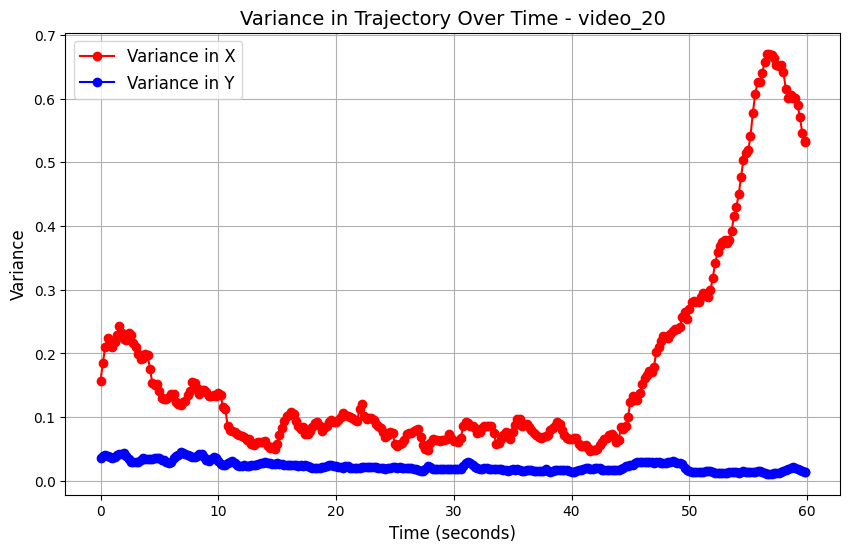

In [53]:
plot_3D_trajectory_with_time(datasets_folder,'Jin_22', 'video_20')

In [57]:
import cv2

In [59]:
def create_saliency_video(data_folder, dataset, vid_name, output_folder):
    # Load the saliency map
    saliency_path = os.path.join(data_folder, dataset, 'true_saliency')
    saliency_maps = np.load(os.path.join(saliency_path, f'{vid_name}.npy'))  # Shape: (t, 256, 256)

    # Set up video parameters
    height, width = saliency_maps.shape[1], saliency_maps.shape[2]
    fps = 5
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')  # Codec for .mp4

    # Create a VideoWriter object
    output_path=os.path.join(output_folder,f'saliency_{vid_name}.mp4')
    out = cv2.VideoWriter(output_path, fourcc, fps, (width, height))

    # Write each saliency map to the video
    for frame in saliency_maps:
        # Normalize saliency map to the range 0-255 for proper video encoding
        normalized_frame = cv2.normalize(frame, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
        # Convert to color (if needed)
        colored_frame = cv2.applyColorMap(normalized_frame, cv2.COLORMAP_JET)  # Apply a colormap
        
        out.write(colored_frame)  # Write frame to video

    # Release the video writer
    out.release()
    print(f'Video saved at {output_path}')

In [60]:
create_saliency_video(datasets_folder,'Jin_22','video_20','saliency_videos')

Video saved at saliency_videos/saliency_video_20.mp4
